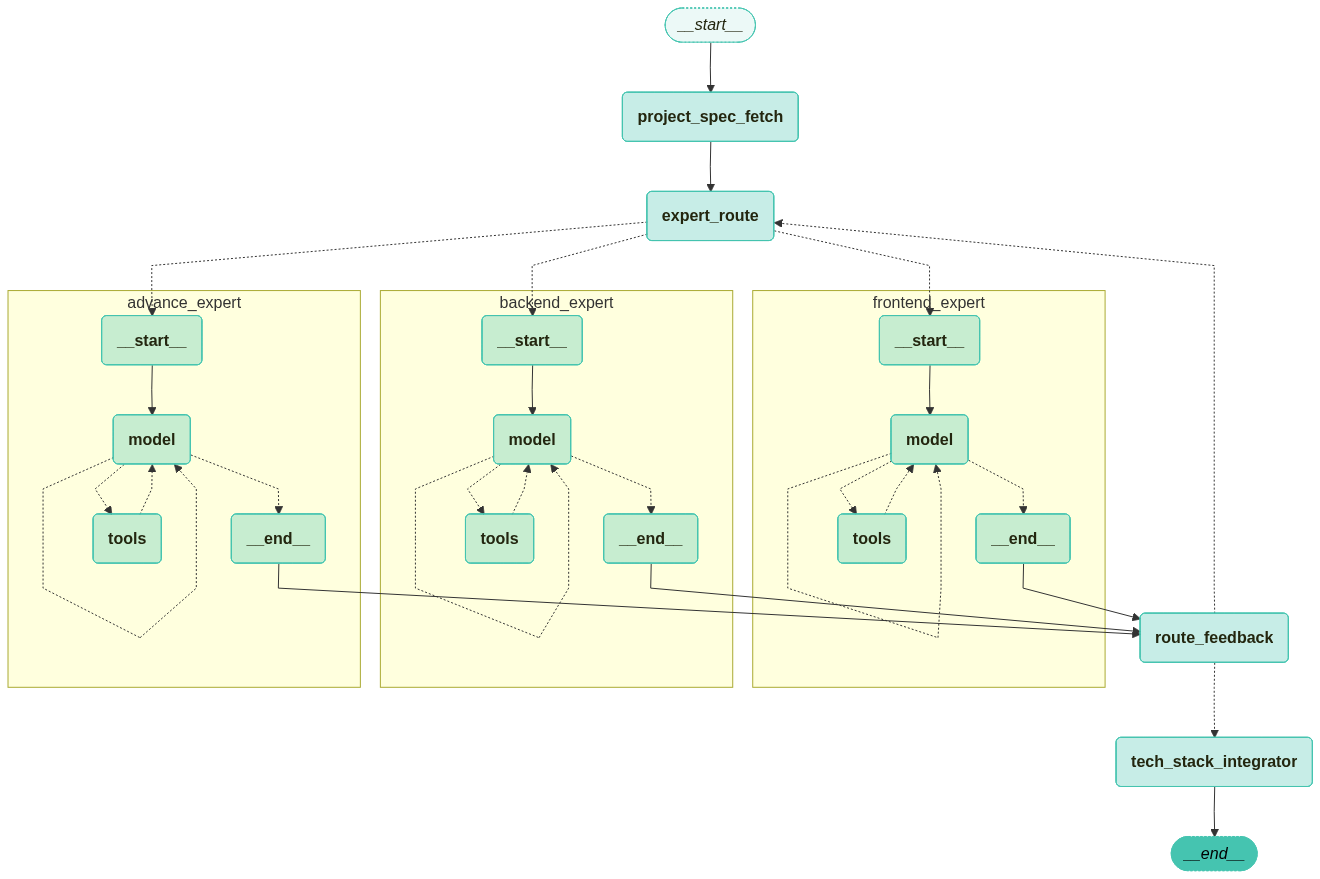

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from app.agents.enums import TaskType
from app.agents.recommend.graph import recommend_graph
from langchain_teddynote.graphs import visualize_graph

visualize_graph(recommend_graph, xray=True)

In [2]:
from app.core.log import langfuse_handler
from app.agents.enums import TaskType  # TaskType Enum이 있다고 가정

test_scenarios = [
    # ----------------------------------------------------------------
    # Case 1: [FE] 복잡한 전역 상태 관리 (Props Drilling vs 상태관리 라이브러리)
    # 목표: 상세한 UI 흐름 속에서 '전역 상태 관리'가 필요함을 캐치하고, Context API vs Redux vs Zustand 등을 비교하는지 확인
    # ----------------------------------------------------------------
    {
        "workspace_id": 1,
        "task_type": TaskType.FRONTEND,
        "node_name": "[FE] 회원가입 마법사(Wizard) 폼 구현",
        "node_description": """
        구현 개요: 총 4단계(약관동의 -> 기본정보 -> 프로필설정 -> 관심사선택)로 구성된 회원가입 마법사를 구현합니다. 각 단계는 별도 라우트(/signup/step1 ~ 4)로 구성되거나 하나의 페이지 내 컴포넌트 전환으로 이루어지며, 사용자가 '이전' 버튼을 눌렀을 때 입력했던 데이터가 그대로 유지되어야 합니다.

        필수사항:
        - 단계별 데이터:
          Step 1: 필수/선택 약관 동의 여부 (Checkbox).
          Step 2: 이메일, 비밀번호, 비밀번호 확인 (유효성 검사 포함).
          Step 3: 닉네임, 프로필 이미지 업로드(미리보기).
          Step 4: 관심 태그 선택 (최소 3개).
        - 상태 유지: Step 3에서 Step 2로 돌아가도 이메일/비밀번호 입력값이 남아있어야 함.
        - 최종 제출: Step 4에서 '가입 완료' 클릭 시 모든 단계의 데이터를 합쳐 POST /api/users 로 전송.
        - 예외 처리: 중간 이탈 시 '임시 저장' 여부를 묻는 모달 팝업.

        구현 힌트:
        - 각 단계가 분리된 컴포넌트이므로 상위 레벨에서 데이터를 관리해야 함.
        - 새로고침 시에도 데이터가 유지되도록 sessionStorage 연동 고려 가능.
        - 입력 폼이 많으므로 렌더링 최적화 필요.

        테스트 포인트:
        1) 2단계 입력 후 3단계 이동 -> 다시 2단계 복귀 시 데이터 유지 확인.
        2) 최종 제출 시 JSON 구조가 { terms: {...}, basic: {...}, profile: {...} } 형태로 올바르게 전송되는지 확인.
        """
    },

    # ----------------------------------------------------------------
    # Case 2: [BE] 고성능 검색 기능 (DB Like 검색 vs Full Text Search 엔진)
    # 목표: '검색' 요구사항을 보고 단순 SQL 'LIKE %...%'가 아니라 ElasticSearch나 DB의 Full-text Indexing 기능을 고려하는지 확인
    # ----------------------------------------------------------------
    {
        "workspace_id": 1,
        "task_type": TaskType.BACKEND,
        "node_name": "[BE] 상품 목록 검색 및 다중 필터 API",
        "node_description": """
        구현 개요: 사용자가 입력한 키워드와 다중 필터 조건을 기반으로 상품 목록을 조회하는 GET /api/products/search API를 구현합니다. 상품 데이터는 약 500만 건 이상이며, 검색 응답 속도는 평균 200ms 이내여야 합니다.

        필수사항:
        - 입력 파라미터: keyword(검색어), category_id, min_price, max_price, brand_ids(배열), sort(price_asc/desc, best, new).
        - 검색 로직:
          1. 'keyword'는 상품명, 브랜드명, 카테고리 태그, 상세 설명을 모두 포함하여 검색(유사어 검색 포함 권장).
          2. 필터 조건은 AND 연산으로 적용.
        - 성능 요구사항: '청바지' 같은 고빈도 키워드 검색 시에도 DB 부하가 적어야 하며, 페이징(Page/Size) 처리가 필수임.
        - 응답 형식: { total_count: 1200, items: [...], facets: { brand: [...], category: [...] } } (검색된 결과 내의 브랜드 분포 등 집계 데이터 포함).

        구현 힌트:
        - RDB(MySQL)의 LIKE 검색으로는 성능 한계가 명확함.
        - 검색 전용 엔진 도입 또는 DB의 Full-text search 기능 활용 필요.
        - 캐싱 전략(Redis)을 병행할 수 있음.

        테스트 포인트:
        1) '나이키' 검색 시 상세 설명에만 '나이키'가 있는 상품도 조회되는지.
        2) 5개 이상의 필터 동시 적용 시 쿼리 타임아웃 발생 여부.
        """
    },

    # ----------------------------------------------------------------
    # Case 3: [BE] 실시간 알림 시스템 (Polling vs SSE vs WebSocket)
    # 목표: '양방향 통신'까지는 필요 없는 '서버 -> 클라이언트' 알림 상황에서 SSE(Server-Sent Events)를 추천 후보에 포함시키는지 확인
    # ----------------------------------------------------------------
    {
        "workspace_id": 1,
        "task_type": TaskType.BACKEND,
        "node_name": "[BE] 주문 배달 상태 실시간 알림",
        "node_description": """
        구현 개요: 사용자가 주문한 음식의 배달 상태(접수됨 -> 조리중 -> 배달중 -> 도착)가 변경될 때마다, 앱/웹 클라이언트에게 실시간으로 토스트 알림을 띄워야 합니다.

        필수사항:
        - Trigger: 사장님 앱에서 '조리 시작' 버튼을 누르면 서버가 이를 감지하여 고객 앱으로 상태 변경 이벤트를 전송.
        - 연결 유지: 고객은 앱을 켜두고 있는 동안 서버와 연결을 유지하며 이벤트를 대기함.
        - 제약 사항: 고객이 서버로 메시지를 보내는 기능(채팅 등)은 없음. 오직 수신만 수행.
        - 재연결 처리: 모바일 네트워크 특성상 연결이 끊어지면 자동 재연결 시도 및 누락된 알림 조회 로직 필요.
        - 확장성: 동시 접속자 10만 명 상황에서도 서버 리소스(Thread/Memory) 점유를 최소화해야 함.

        구현 힌트:
        - 주기적으로 API를 호출하는(Polling) 방식은 서버 부하 및 실시간성 문제로 지양.
        - 양방향 통신(Socket)이 굳이 필요한지 검토 필요.

        테스트 포인트:
        1) 백엔드 API로 상태 변경 요청(POST /api/orders/{id}/status) 시 클라이언트에 즉시 알림 도착 여부.
        2) 브라우저 탭을 닫았다 켰을 때 재연결 동작.
        """
    },

    # ----------------------------------------------------------------
    # Case 4: [Advance] 분산 트랜잭션 처리 (Saga Pattern vs 2PC)
    # 목표: 마이크로서비스 환경의 데이터 정합성 문제를 해결하기 위해 'Saga Pattern'이나 'Outbox Pattern' 같은 아키텍처 패턴을 제시하는지 확인
    # ----------------------------------------------------------------
    {
        "workspace_id": 1,
        "task_type": TaskType.ADVANCE,
        "node_name": "[Advance] 결제-주문-재고 서비스 간 데이터 일관성 보장",
        "node_description": """
        구현 개요: 현재 모놀리식에서 MSA로 전환 중입니다. 사용자가 '결제'를 완료하면 [결제 서비스] -> [주문 서비스(상태변경)] -> [재고 서비스(차감)]가 순차적으로 이루어져야 합니다.

        문제 상황:
        - 결제는 성공했는데, 재고 차감에서 DB 에러가 발생하면 결제를 취소(환불)하고 주문 상태를 되돌려야 함.
        - 각 서비스는 서로 다른 DB를 사용하고 있어 DB 트랜잭션(@Transactional)으로 묶을 수 없음.
        - 현재는 HTTP 요청으로 처리 중이라 중간에 타임아웃 나면 데이터 불일치 발생.

        요구사항:
        - 분산 환경에서 '결제-주문-재고'의 원자성(All or Nothing)을 보장하는 트랜잭션 관리 기법 도입.
        - 실패 시 보상 트랜잭션(Compensating Transaction) 실행 로직 필요.
        - 성능 저하가 심한 2PC(Two-Phase Commit) 방식은 지양.

        구현 힌트:
        - 메시지 큐(Kafka/RabbitMQ)를 활용한 이벤트 기반 설계를 고려.
        - Orchestration 기반 또는 Choreography 기반의 패턴 적용 필요.

        테스트 포인트:
        1) 재고 부족으로 로직 실패 시, 이미 승인된 결제가 자동으로 취소되는지 확인.
        """
    }
]

ouput = recommend_graph.invoke(test_scenarios[3], config={"callbacks": [langfuse_handler]})

내용 검증 실패 (시도 1/5): [내용 검증 실패 - 점수: 6]
피드백: 개선 가이드:
1) 동일 계층성 유지: 현재 추천된 세 가지 항목은 모두 '분산 트랜잭션/아키텍처 패턴' 계층으로 대체로 일치하므로 이 ...


In [3]:
# indent=4를 주어 예쁘게 출력
json_string = ouput['tech_list'].model_dump_json(indent=2)
print(json_string)

{
  "techs": [
    {
      "id": "50060",
      "name": "saga-orchestration",
      "advantage": "전체 흐름을 중앙에서 제어하므로 복구/관리를 쉽게 구현할 수 있고, 복잡한 비즈니스 로직(조건 분기, 타임아웃, 재시도 정책 등)을 Orchestrator에 집중시켜 단일 책임으로 관리하기 용이함. 장애 시 전체 Saga의 상태를 추적·재개하기 쉬움.",
      "disadvantage": "Orchestrator가 논리적 단일 제어점이 되어 SPOF가 될 수 있고, 오케스트레이터 구현·운영 복잡도가 높음. 메시지 지연/비동기성으로 인한 응답 지연과 오케스트레이터의 상태 저장소(예: Saga 상태 DB) 설계와 성능 고려 필요.",
      "description": "Orchestration 기반 SAGA: 중앙에 Saga Orchestrator(또는 Saga Manager)를 두고, 오케스트레이터가 각 서비스에 명령(Command)을 순차 실행하고 실패 시 보상 호출(Compensating Transaction)을 지시하는 방식.",
      "ref": "https://jinwookoh.tistory.com/232",
      "recommendation_score": 4
    },
    {
      "id": "50061",
      "name": "saga-choreography",
      "advantage": "서비스 간의 결합도가 낮아 확장성·독립 배포에 유리하고 특정 중앙 컴포넌트 없이 자연스럽게 이벤트 흐름을 통해 분산 트랜잭션을 구성할 수 있음. 메시지 큐(Kafka/RabbitMQ)와 잘 맞아 높은 처리량을 얻기 쉬움.",
      "disadvantage": "복잡한 흐름(특히 분기나 동기적 검사)이 많으면 이벤트 흐름이 난해해지고, 전체 Saga의 상태 추적(관찰성, 디버깅)이 어려움. 보상 로직이 분산되어 테스트·운영 난이도가 증가할 수 있